In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../')
from eda import utils

In [47]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [48]:
tracks

album                                                              \
         comments        date_created date_released engineer favorites     id   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4      1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4      6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2      4   
...           ...                 ...           ...      ...       ...    ...   
155316          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155317          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155318          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155319          0 2017-03-30 15:20:35    2017-02-17      NaN         0  22940   
155320          0 2017-03-26 16:22:18    2017-03-26      NaN         1  22906   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
3                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
20                <p> "spiritual songs" from Nicky Cook</p>    2710   
...                                                     ...     ...   
155316    <p>A live performance at Monty Hall on Feb 17,...    1506   
155317    <p>A live performance at Monty Hall on Feb 17,...    1506   
155318    <p>A live performance at Monty Hall on Feb 17,...    1506   
155319    <p>A live performance at Monty Hall on Feb 17,...    1506   
155320                                                  NaN    7481   

                                                                          ...  \
             producer                                               tags  ...   
track_id                                                                  ...   
2                 NaN                                                 []  ...   
3                 NaN                                                 []  ...   
5                 NaN                                                 []  ...   
10                NaN                                                 []  ...   
20                NaN                                                 []  ...   
...               ...                                                ...  ...   
155316    Monty Hall                                                  []  ...   
155317    Monty Hall                                                  []  ...   
155318    Monty Hall                                                  []  ...   
155319    Monty Hall                                                  []  ...   
155320            NaN  [ballad, epic, rockabilly, curse, hex, hard ro...  ...   

               track                         \
         information interest language_code   
track_id                                      
2                NaN     4656            en   
3                NaN     1470            en   
5                NaN     1933            en   
10               NaN    54881            en   
20               NaN      978            en   
...              ...      ...           ...   
155316           NaN      122           NaN   
155317           NaN      194           NaN   
155318           NaN      214           NaN   
155319           NaN      336           NaN   
155320           NaN      972           NaN   

                                                                              \
        

In [60]:
from sklearn.preprocessing import StandardScaler


def get_all():
    large = tracks['set', 'subset'] <= 'large'

    genre1 = tracks['track', 'genre_top'] == 'Rock'
    genre2 = tracks['track', 'genre_top'] == 'Folk'
    genre3 = tracks['track', 'genre_top'] == 'Electronic'
    genre4 = tracks['track', 'genre_top'] == 'Instrumental'
    genre5 = tracks['track', 'genre_top'] == 'Hip-Hop'

    train = tracks['set', 'split'] == 'training'
    val = tracks['set', 'split'] == 'validation'
    test = tracks['set', 'split'] == 'test'

    y_train = tracks.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    y_test = tracks.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    X_train = features.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    X_test = features.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_all()
X_train.shape


(25820, 518)

In [50]:
from sklearn.decomposition import PCA
def pca_preprocess(X_train, X_test):
	X_train = StandardScaler().fit_transform(X_train)
	X_test = StandardScaler().fit_transform(X_test)
	pca = PCA(n_components=10)
	pca.fit(X_train)
	print("Explained Variance", pca.explained_variance_ratio_[:10])
	print("Singular Values", pca.singular_values_[:10])
	X_train = pca.fit_transform(X_train)
	X_test = pca.transform(X_test)
	return X_train, X_test

In [51]:
X_train, X_test = pca_preprocess(X_train, X_test)
X_train.shape

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Explained Variance [0.1105265  0.07470014 0.04221172 0.03150036 0.02957833 0.02646481
 0.02575648 0.02447041 0.02373768 0.01978944]
Singular Values [1215.83940128  999.54809175  751.37981644  649.08382063  628.96981411
  594.9458234   586.92994163  572.08905153  563.45881113  514.46967366]


(25820, 10)

In [52]:
y_test.unique()

['Rock', 'Folk', 'Electronic', 'Instrumental', 'Hip-Hop']
Categories (5, object): ['Rock', 'Folk', 'Electronic', 'Instrumental', 'Hip-Hop']

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [10, 100, 200, 300, 500, 1000],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                         return_train_score=False,
                         n_iter=6)
knn.fit(X_train, y_train)

knn.best_params_


{'weights': 'distance', 'n_neighbors': 100, 'algorithm': 'ball_tree'}

In [54]:
pd.DataFrame(knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026323,0.005196,3.206519,0.223505,distance,1000,ball_tree,"{'weights': 'distance', 'n_neighbors': 1000, '...",0.599923,0.609605,0.611929,0.644074,0.614640,0.616034,0.014873,6
1,0.024292,0.001368,1.245197,0.021841,distance,10,ball_tree,"{'weights': 'distance', 'n_neighbors': 10, 'al...",0.624129,0.626452,0.636716,0.665957,0.629163,0.636483,0.015333,3
2,0.035554,0.008577,2.654766,0.493024,distance,500,kd_tree,"{'weights': 'distance', 'n_neighbors': 500, 'a...",0.613865,0.621224,0.627614,0.658211,0.627421,0.629667,0.015133,5
3,0.040619,0.010240,2.391748,0.120233,distance,100,ball_tree,"{'weights': 'distance', 'n_neighbors': 100, 'a...",0.632068,0.634586,0.643687,0.676607,0.645043,0.646398,0.015916,1
4,0.056696,0.011000,3.016724,0.424229,uniform,300,auto,"{'weights': 'uniform', 'n_neighbors': 300, 'al...",0.614253,0.625290,0.630713,0.658985,0.631875,0.632223,0.014762,4
5,0.011144,0.000767,1.684313,0.060747,uniform,200,brute,"{'weights': 'uniform', 'n_neighbors': 200, 'al...",0.621418,0.629163,0.638652,0.664988,0.636909,0.638226,0.014716,2


              precision    recall  f1-score   support

  Electronic       0.63      0.69      0.66       839
        Folk       0.34      0.36      0.35       299
     Hip-Hop       0.59      0.37      0.45       323
Instrumental       0.70      0.06      0.11       309
        Rock       0.73      0.88      0.80      1464

    accuracy                           0.65      3234
   macro avg       0.60      0.47      0.47      3234
weighted avg       0.65      0.65      0.62      3234



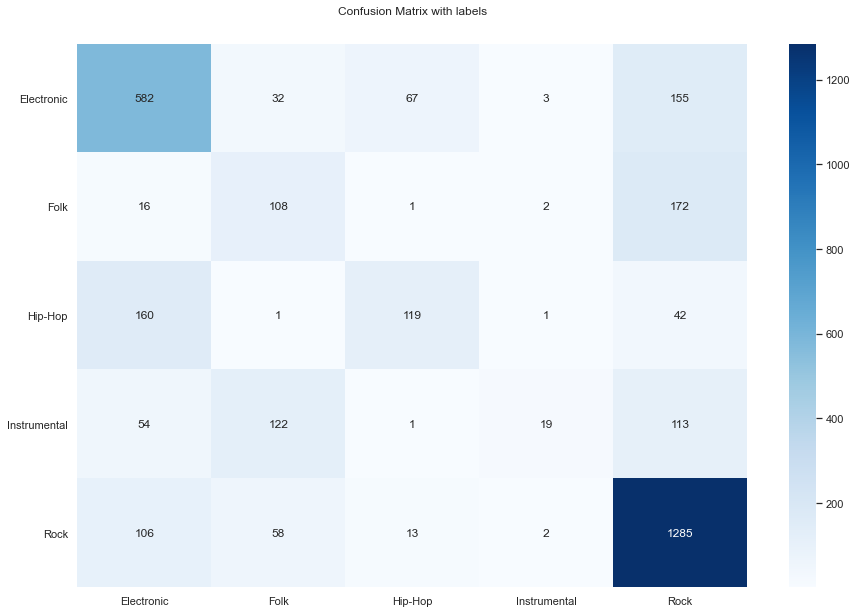

In [55]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="brute")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()

In [69]:
from sklearn.manifold import TSNE

def tsne_preprocess(X_train, X_test):
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    tsne = TSNE(n_components=2)
    tsne.fit(X_train)
    X_train = tsne.fit_transform(X_train)
    X_test = tsne.fit_transform(X_test)
    return X_train, X_test

X_train.shape


(25820, 2)

In [68]:
X_train, X_test, y_train, y_test = get_all()
X_train, X_test = tsne_preprocess(X_train, X_test)

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklea

              precision    recall  f1-score   support

  Electronic       0.33      0.38      0.35       839
        Folk       0.01      0.00      0.00       299
     Hip-Hop       0.03      0.02      0.03       323
Instrumental       0.00      0.00      0.00       309
        Rock       0.62      0.81      0.70      1464

    accuracy                           0.47      3234
   macro avg       0.20      0.24      0.22      3234
weighted avg       0.37      0.47      0.41      3234



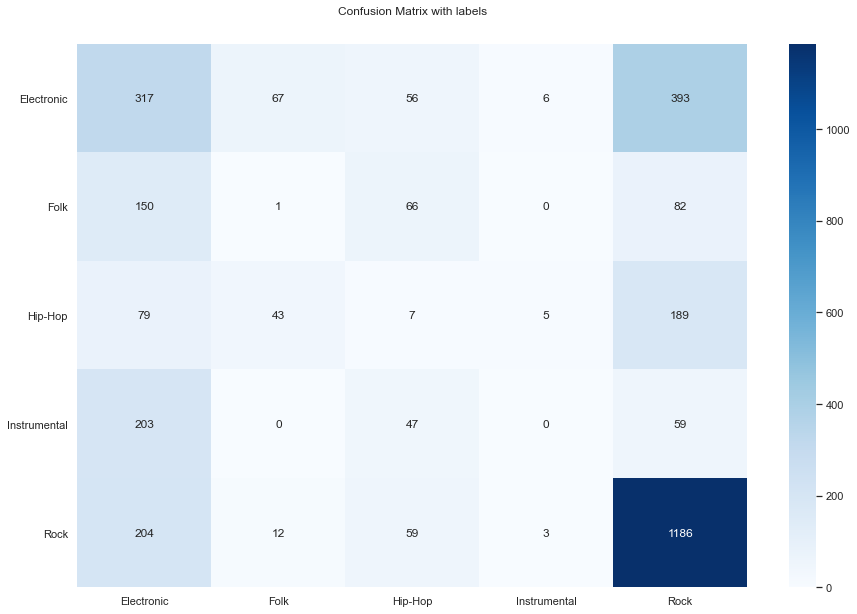

In [70]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="brute")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()